# Introduction

Hello! Welcome to this notebook, thank you for your interest and time. The goal here is to take data about housing sales in Ames, Iowa from 2006 to 2010 and to create a machine learning model that can acccurately predict the sale price of one such home. A description of each column in the dataset can be found [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

We'll create three functions that act as a pipeline through which to transform the data into ML-friendly formats, select which features are most useful, and to train and test ML models.



Game Plan:
1. transform features
 - get rid of columns missing 5% or more of the total values
 - get rid of text columns with any missing values
 - impute remaining missing values using either the mean or the mode of the column
 - add any new features that better represent the relationship to the target column (the sale price)
2. select features
 - find which features correlate most strongly with the target 
 - find only most useful features by determining a cutoff of number of unique values allowed
 - convert non-useful numerical data into categorical data and dummy code these new values into the existing df
3. train and test model
 - use different algorithms and validation techniques to create the best model you can

# Creating The Initial Functions

First, we'll import the necessary libraries and read in the data and create placeholders for each of the three steps mentioned above. 

From there, we'll create cells where we'll experiment with what will eventually fill up the body of each of these placeholder functions, going in order through each of the three.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score

In [2]:
pd.set_option('display.max_rows', 500)

In [3]:
data = pd.read_csv('AmesHousing.tsv', delimiter='\t')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [5]:
def transform_features(df):
    return df

def select_features(df):
    df = df[['Gr Liv Area', 'SalePrice']]
    return df

def train_and_test(df):
    testing_cutoff = int(len(df) / 2)
    
    features = df.columns.drop('SalePrice')
    target = 'SalePrice'
    
    train_df = df[:testing_cutoff]
    test_df = df[testing_cutoff:]
    
    lr = LinearRegression()
    lr.fit(train_df[features], train_df[target])
    predictions = lr.predict(test_df[features])
    mse = mean_squared_error(test_df[target], predictions)
    rmse = np.sqrt(mse)
    
    return rmse


In [6]:
transformed_df = transform_features(data)
features_df = select_features(transformed_df)
rmse = train_and_test(features_df)
rmse

57120.50729008638

The workflow above will be consistent as we move through this process:
1. We'll transform the original dataframe
2. We'll select the features we find useful for the modelling
3. We'll fit and run the model

As a sidenote, the model we've mocked up here (which is using the entire original dataset) has an rmse of 57,120.5. We'll look to improve upon this as we work. The smaller the value of the rmse, the more accurate the model's performance. My personal goal is to create a model with an rmse of 28,654 or less.

# Transforming the Features 

At the beginning, we listed three goals for this section, which I will reiterate here:
- get rid of columns missing 5% or more of the total values
- get rid of text columns with any missing values
- impute remaining missing values using either the mean or the mode of the column
- add any new features that better represent the relationship to the target column (the sale price)


In [7]:
null_cols = data.isnull().sum()
missing_limit = int(len(data) * 0.05)

ample_data = data[null_cols[null_cols < missing_limit].index]
ample_data.isnull().sum()


Order               0
PID                 0
MS SubClass         0
MS Zoning           0
Lot Area            0
Street              0
Lot Shape           0
Land Contour        0
Utilities           0
Lot Config          0
Land Slope          0
Neighborhood        0
Condition 1         0
Condition 2         0
Bldg Type           0
House Style         0
Overall Qual        0
Overall Cond        0
Year Built          0
Year Remod/Add      0
Roof Style          0
Roof Matl           0
Exterior 1st        0
Exterior 2nd        0
Mas Vnr Type       23
Mas Vnr Area       23
Exter Qual          0
Exter Cond          0
Foundation          0
Bsmt Qual          80
Bsmt Cond          80
Bsmt Exposure      83
BsmtFin Type 1     80
BsmtFin SF 1        1
BsmtFin Type 2     81
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
Heating             0
Heating QC          0
Central Air         0
Electrical          1
1st Flr SF          0
2nd Flr SF          0
Low Qual Fin SF     0
Gr Liv Are

In [8]:
# selecting just the with text values
text_columns = data.select_dtypes(include=['object'])
null_text = text_columns.isnull().sum().sort_values(ascending=False)

# identifying the columns that have at least 1 missing value
text_missing = data[null_text[null_text > 0].index]

# dropping those columns from the existing dataframe
no_missing = data.drop(text_missing.columns, axis=1)

# confirming there are no missing text columns
no_missing.isnull().sum()


Order                0
PID                  0
MS SubClass          0
MS Zoning            0
Lot Frontage       490
Lot Area             0
Street               0
Lot Shape            0
Land Contour         0
Utilities            0
Lot Config           0
Land Slope           0
Neighborhood         0
Condition 1          0
Condition 2          0
Bldg Type            0
House Style          0
Overall Qual         0
Overall Cond         0
Year Built           0
Year Remod/Add       0
Roof Style           0
Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Mas Vnr Area        23
Exter Qual           0
Exter Cond           0
Foundation           0
BsmtFin SF 1         1
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Heating              0
Heating QC           0
Central Air          0
1st Flr SF           0
2nd Flr SF           0
Low Qual Fin SF      0
Gr Liv Area          0
Bsmt Full Bath       2
Bsmt Half Bath       2
Full Bath            0
Half Bath  

In [9]:
df_nulls = data.select_dtypes(include=['number']).isnull().sum()
df_nulls_exist = df_nulls > 0 
nulls_only_df = data[df_nulls[df_nulls_exist].index]
replacement_dict = nulls_only_df.mode().to_dict(orient='records')[0]
replacement_dict


{'Lot Frontage': 60.0,
 'Mas Vnr Area': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Bsmt Unf SF': 0.0,
 'Total Bsmt SF': 0.0,
 'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Garage Yr Blt': 2005.0,
 'Garage Cars': 2.0,
 'Garage Area': 0.0}

In [10]:
data = data.fillna(replacement_dict)
data[df_nulls_exist.index].isnull().sum()

Order              0
PID                0
MS SubClass        0
Lot Frontage       0
Lot Area           0
Overall Qual       0
Overall Cond       0
Year Built         0
Year Remod/Add     0
Mas Vnr Area       0
BsmtFin SF 1       0
BsmtFin SF 2       0
Bsmt Unf SF        0
Total Bsmt SF      0
1st Flr SF         0
2nd Flr SF         0
Low Qual Fin SF    0
Gr Liv Area        0
Bsmt Full Bath     0
Bsmt Half Bath     0
Full Bath          0
Half Bath          0
Bedroom AbvGr      0
Kitchen AbvGr      0
TotRms AbvGrd      0
Fireplaces         0
Garage Yr Blt      0
Garage Cars        0
Garage Area        0
Wood Deck SF       0
Open Porch SF      0
Enclosed Porch     0
3Ssn Porch         0
Screen Porch       0
Pool Area          0
Misc Val           0
Mo Sold            0
Yr Sold            0
SalePrice          0
dtype: int64

Let's make a feature that describes how recently it had been remodeled before it was sold. This is more meaningful data than strictly what year it was remodeled. 

We'll also make a feature about how long the house took to sell since it was built.

Finally, for both of these two features, we need to address any "impossible" values; it's not possible for either of these to be negative. We'll delete any rows where this is the case.

In [11]:
data['Years_Since_Remod'] = data['Yr Sold'] - data['Year Remod/Add']
data['Years_Until_Sold'] = data['Yr Sold'] - data['Year Built']

In [12]:
data[data['Years_Since_Remod'] < 0].index

Int64Index([1702, 2180, 2181], dtype='int64')

In [13]:
data[data['Years_Until_Sold'] < 0].index

Int64Index([2180], dtype='int64')

In [14]:
data = data.drop([1702, 2180, 2181], axis=0)

In [15]:
unwanted_columns = ['Order', 'PID', 'Mo Sold', 'Sale Type', 'Sale Condition']
data = data.drop(unwanted_columns, axis=1)

In [16]:
data = pd.read_csv('AmesHousing.tsv', delimiter='\t')

def transform_features(df):
    
    # getting rid of columns missing 5% or more of the total values
    null_cols = df.isnull().sum()
    missing_limit = int(len(data) * 0.05)
    df = data[null_cols[null_cols < missing_limit].index]
    
    # getting rid of text columns with any missing values
    text_columns = df.select_dtypes(include=['object'])
    null_text = text_columns.isnull().sum().sort_values(ascending=False)
    text_missing = df[null_text[null_text > 0].index]
    no_missing = df.drop(text_missing.columns, axis=1)
    
    # replacing any remaining missing values with the mode of the column
    df_nulls = df.select_dtypes(include=['number']).isnull().sum()
    df_nulls_exist = df_nulls > 0 
    nulls_only_df = df[df_nulls[df_nulls_exist].index]
    replacement_dict = nulls_only_df.mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_dict)

    # adding new features and removing the less useful features they came from 
    df['Years_Since_Remod'] = df['Yr Sold'] - df['Year Remod/Add']
    df['Years_Until_Sold'] = df['Yr Sold'] - df['Year Built']
    df = df.drop([1702, 2180, 2181], axis=0)
    unwanted_columns = ['Order', 'PID', 'Mo Sold', 'Year Remod/Add', 'Year Built', 'Sale Type', 'Sale Condition']
    df = df.drop(unwanted_columns, axis=1)
    
    return df

In [17]:
# confirmation that this function runs properly 
transform_func_test = transform_features(data)
transform_func_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 66 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MS SubClass        2927 non-null   int64  
 1   MS Zoning          2927 non-null   object 
 2   Lot Area           2927 non-null   int64  
 3   Street             2927 non-null   object 
 4   Lot Shape          2927 non-null   object 
 5   Land Contour       2927 non-null   object 
 6   Utilities          2927 non-null   object 
 7   Lot Config         2927 non-null   object 
 8   Land Slope         2927 non-null   object 
 9   Neighborhood       2927 non-null   object 
 10  Condition 1        2927 non-null   object 
 11  Condition 2        2927 non-null   object 
 12  Bldg Type          2927 non-null   object 
 13  House Style        2927 non-null   object 
 14  Overall Qual       2927 non-null   int64  
 15  Overall Cond       2927 non-null   int64  
 16  Roof Style         2927 

# Selecting Features

Moving to the second function we've outlined, it's time to select which are the most relevant features for our model to use. Again, the goals of this section are to:

- find which features correlate most strongly with the target
- find only most useful features by determining a cutoff of number of unique values allowed
- convert non-useful numerical data into categorical data and dummy code these new values into the existing df

In [18]:
transformed_df = transform_features(data)

In [19]:
corr_df = transformed_df.corr().abs()
sorted_corrs = corr_df['SalePrice'].sort_values(ascending=False)
worst_corrs = sorted_corrs[sorted_corrs < 0.5]
worst_corrs


transformed_df = transformed_df.drop(worst_corrs.index, axis=1)
transformed_df

# transformed_df = transformed_df[top_corrs.index]
# transformed_df
# top_corrs['SalePrice'].sort_values(ascending=False)


,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,...,Gr Liv Area,Full Bath,Kitchen Qual,Functional,Garage Cars,Garage Area,Paved Drive,SalePrice,Years_Since_Remod,Years_Until_Sold
0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,1656,1,TA,Typ,2.0,528.0,P,215000,50,50
1,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,...,896,1,TA,Typ,1.0,730.0,Y,105000,49,49
2,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,1329,1,Gd,Typ,1.0,312.0,Y,172000,52,52
3,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,2110,2,Ex,Typ,2.0,522.0,Y,244000,42,42
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,1629,2,TA,Typ,2.0,482.0,Y,189900,12,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,RL,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,...,1003,1,TA,Typ,2.0,588.0,Y,142500,22,22
2926,RL,Pave,IR1,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,...,902,1,TA,Typ,2.0,484.0,Y,131000,23,23
2927,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,...,970,1,TA,Typ,0.0,0.0,Y,132000,14,14
2928,RL,Pave,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,...,1389,1,TA,Typ,2.0,418.0,Y,170000,31,32


<AxesSubplot:>

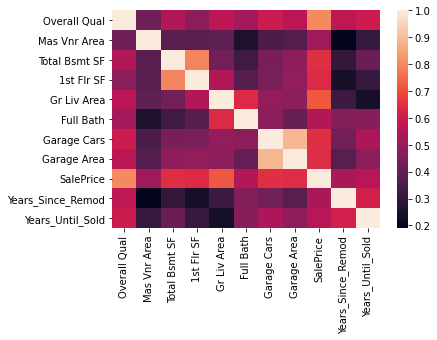

In [20]:
heat = transformed_df.corr().abs()
sns.heatmap(heat)

In [21]:
nominal_features = ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Lot Shape', 
                    'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 
                    'Condition1', 'Conditiion2', 'BldgType', 'House Style', 'Roof Style', 
                    'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 
                    'Exter Cond', 'Foundation', 'Heating', 'Central Air', 'Electrical', 
                    'Garage Type', 'Misc Feature', 'Sale Type', 'Sale Condition']

In [22]:
useful_only = []
for col in nominal_features:
    if col in transformed_df.columns:
        useful_only.append(col)
        
useful_only

['MS Zoning',
 'Street',
 'Lot Shape',
 'Land Contour',
 'Utilities',
 'Lot Config',
 'Land Slope',
 'Neighborhood',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Exter Qual',
 'Exter Cond',
 'Foundation',
 'Heating',
 'Central Air',
 'Electrical']

In [23]:
unique_vals = transformed_df[useful_only].apply(lambda col: len(col.value_counts())).sort_values()
unique_vals

Street           2
Central Air      2
Utilities        3
Land Slope       3
Lot Shape        4
Land Contour     4
Exter Qual       4
Electrical       5
Lot Config       5
Exter Cond       5
Mas Vnr Type     5
Heating          6
Foundation       6
Roof Style       6
MS Zoning        7
Roof Matl        8
House Style      8
Exterior 1st    16
Exterior 2nd    17
Neighborhood    28
dtype: int64

In [24]:
unacceptable_values = unique_vals[unique_vals < 10].index
unacceptable_values

Index(['Street', 'Central Air', 'Utilities', 'Land Slope', 'Lot Shape',
       'Land Contour', 'Exter Qual', 'Electrical', 'Lot Config', 'Exter Cond',
       'Mas Vnr Type', 'Heating', 'Foundation', 'Roof Style', 'MS Zoning',
       'Roof Matl', 'House Style'],
      dtype='object')

In [25]:
transformed_df = transformed_df.drop(unacceptable_values, axis=1)
transformed_df

,Neighborhood,Condition 1,Condition 2,Bldg Type,Overall Qual,Exterior 1st,Exterior 2nd,Mas Vnr Area,Bsmt Qual,Bsmt Cond,...,Gr Liv Area,Full Bath,Kitchen Qual,Functional,Garage Cars,Garage Area,Paved Drive,SalePrice,Years_Since_Remod,Years_Until_Sold
0,NAmes,Norm,Norm,1Fam,6,BrkFace,Plywood,112.0,TA,Gd,...,1656,1,TA,Typ,2.0,528.0,P,215000,50,50
1,NAmes,Feedr,Norm,1Fam,5,VinylSd,VinylSd,0.0,TA,TA,...,896,1,TA,Typ,1.0,730.0,Y,105000,49,49
2,NAmes,Norm,Norm,1Fam,6,Wd Sdng,Wd Sdng,108.0,TA,TA,...,1329,1,Gd,Typ,1.0,312.0,Y,172000,52,52
3,NAmes,Norm,Norm,1Fam,7,BrkFace,BrkFace,0.0,TA,TA,...,2110,2,Ex,Typ,2.0,522.0,Y,244000,42,42
4,Gilbert,Norm,Norm,1Fam,5,VinylSd,VinylSd,0.0,Gd,TA,...,1629,2,TA,Typ,2.0,482.0,Y,189900,12,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,Mitchel,Norm,Norm,1Fam,6,HdBoard,HdBoard,0.0,TA,TA,...,1003,1,TA,Typ,2.0,588.0,Y,142500,22,22
2926,Mitchel,Norm,Norm,1Fam,5,HdBoard,HdBoard,0.0,Gd,TA,...,902,1,TA,Typ,2.0,484.0,Y,131000,23,23
2927,Mitchel,Norm,Norm,1Fam,5,HdBoard,Wd Shng,0.0,Gd,TA,...,970,1,TA,Typ,0.0,0.0,Y,132000,14,14
2928,Mitchel,Norm,Norm,1Fam,5,HdBoard,HdBoard,0.0,Gd,TA,...,1389,1,TA,Typ,2.0,418.0,Y,170000,31,32


In [26]:
text_cols = transformed_df.select_dtypes(include=['object'])

for col in text_cols:
    transformed_df[col] = transformed_df[col].astype('category')

In [27]:
for col in text_cols:
    dum = pd.get_dummies(transformed_df[col])
    transformed_df = pd.concat([transformed_df, dum], axis=1)
    del transformed_df[col]

In [28]:
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Columns: 141 entries, Overall Qual to Y
dtypes: float64(4), int64(7), uint8(130)
memory usage: 646.0 KB


In [29]:
data = pd.read_csv('AmesHousing.tsv', delimiter='\t')

def transform_features(df):
    
    # getting rid of columns missing 5% or more of the total values
    null_cols = df.isnull().sum()
    missing_limit = int(len(data) * 0.05)
    df = data[null_cols[null_cols < missing_limit].index]
    
    # getting rid of text columns with any missing values
    text_columns = df.select_dtypes(include=['object'])
    null_text = text_columns.isnull().sum().sort_values(ascending=False)
    text_missing = df[null_text[null_text > 0].index]
    no_missing = df.drop(text_missing.columns, axis=1)
    
    # replacing any remaining missing values with the mode of the column
    df_nulls = df.select_dtypes(include=['number']).isnull().sum()
    df_nulls_exist = df_nulls > 0 
    nulls_only_df = df[df_nulls[df_nulls_exist].index]
    replacement_dict = nulls_only_df.mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_dict)

    # adding new features and removing the less useful features they came from 
    df['Years_Since_Remod'] = df['Yr Sold'] - df['Year Remod/Add']
    df['Years_Until_Sold'] = df['Yr Sold'] - df['Year Built']
    df = df.drop([1702, 2180, 2181], axis=0)
    unwanted_columns = ['Order', 'PID', 'Mo Sold', 'Year Remod/Add', 'Year Built', 'Sale Type', 'Sale Condition']
    df = df.drop(unwanted_columns, axis=1)
    
    return df


def select_features(df):
    
    # finding which features correlate most strongly with the target
    corr_df = df.corr().abs()
    sorted_corrs = corr_df['SalePrice'].sort_values(ascending=False)
    worst_corrs = sorted_corrs[sorted_corrs < 0.5]
    df = df.drop(worst_corrs.index, axis=1)
    
    # finding only most useful features by determining a cutoff of number of unique values allowed
    nominal_features = ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Lot Shape', 
                    'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 
                    'Condition1', 'Conditiion2', 'BldgType', 'House Style', 'Roof Style', 
                    'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 
                    'Exter Cond', 'Foundation', 'Heating', 'Central Air', 'Electrical', 
                    'Garage Type', 'Misc Feature', 'Sale Type', 'Sale Condition']
    
    useful_only = []
    for col in nominal_features:
        if col in df.columns:
            useful_only.append(col)
            
    unique_vals = df[useful_only].apply(lambda col: len(col.value_counts())).sort_values()
    unacceptable_values = unique_vals[unique_vals < 10].index
    df = df.drop(unacceptable_values, axis=1)
    
    # convert non-useful numerical data into categorical data and dummy code these new values into the existing df
    text_cols = df.select_dtypes(include=['object'])

    for col in text_cols:
        df[col] = df[col].astype('category')
    
    for col in text_cols:
        dum = pd.get_dummies(df[col])
        df = pd.concat([df, dum], axis=1)
        del df[col]
    
    return df

In [30]:
# confirmation that these two functions run properly 
transform_func_test = transform_features(data)
select_features_test = select_features(transform_func_test)
select_features_test


,Overall Qual,Mas Vnr Area,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,Garage Cars,Garage Area,SalePrice,Years_Since_Remod,...,Maj2,Min1,Min2,Mod,Sal,Sev,Typ,N,P,Y
0,6,112.0,1080.0,1656,1656,1,2.0,528.0,215000,50,...,0,0,0,0,0,0,1,0,1,0
1,5,0.0,882.0,896,896,1,1.0,730.0,105000,49,...,0,0,0,0,0,0,1,0,0,1
2,6,108.0,1329.0,1329,1329,1,1.0,312.0,172000,52,...,0,0,0,0,0,0,1,0,0,1
3,7,0.0,2110.0,2110,2110,2,2.0,522.0,244000,42,...,0,0,0,0,0,0,1,0,0,1
4,5,0.0,928.0,928,1629,2,2.0,482.0,189900,12,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,6,0.0,1003.0,1003,1003,1,2.0,588.0,142500,22,...,0,0,0,0,0,0,1,0,0,1
2926,5,0.0,864.0,902,902,1,2.0,484.0,131000,23,...,0,0,0,0,0,0,1,0,0,1
2927,5,0.0,912.0,970,970,1,0.0,0.0,132000,14,...,0,0,0,0,0,0,1,0,0,1
2928,5,0.0,1389.0,1389,1389,1,2.0,418.0,170000,31,...,0,0,0,0,0,0,1,0,0,1


# Training and Testing Models

Now that we have established features we'd like to use, and can easily manipulate them (such as changing the cutoffs for the strongest correlations, or the number of unique values in the categorical features), it's time to train and fit models! 

Here again, the plan for this stage of the process from the introduction:
 - use different algorithms and validation techniques to create the best model you can

In [31]:
data = pd.read_csv('AmesHousing.tsv', delimiter='\t')

def transform_features(df):
    
    # getting rid of columns missing 5% or more of the total values
    null_cols = df.isnull().sum()
    missing_limit = int(len(data) * 0.05)
    df = data[null_cols[null_cols < missing_limit].index]
    
    # getting rid of text columns with any missing values
    text_columns = df.select_dtypes(include=['object'])
    null_text = text_columns.isnull().sum().sort_values(ascending=False)
    text_missing = df[null_text[null_text > 0].index]
    no_missing = df.drop(text_missing.columns, axis=1)
    
    # replacing any remaining missing values with the mode of the column
    df_nulls = df.select_dtypes(include=['number']).isnull().sum()
    df_nulls_exist = df_nulls > 0 
    nulls_only_df = df[df_nulls[df_nulls_exist].index]
    replacement_dict = nulls_only_df.mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_dict)

    # adding new features and removing the less useful features they came from 
    df['Years_Since_Remod'] = df['Yr Sold'] - df['Year Remod/Add']
    df['Years_Until_Sold'] = df['Yr Sold'] - df['Year Built']
    df = df.drop([1702, 2180, 2181], axis=0)
    unwanted_columns = ['Order', 'PID', 'Mo Sold', 'Year Remod/Add', 'Year Built', 'Sale Type', 'Sale Condition']
    df = df.drop(unwanted_columns, axis=1)
    
    return df


def select_features(df):
    
    # finding which features correlate most strongly with the target
    corr_df = df.corr().abs()
    sorted_corrs = corr_df['SalePrice'].sort_values(ascending=False)
    worst_corrs = sorted_corrs[sorted_corrs < 0.4]
    df = df.drop(worst_corrs.index, axis=1)
    
    # finding only most useful features by determining a cutoff of number of unique values allowed
    nominal_features = ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Lot Shape', 
                    'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 
                    'Condition1', 'Conditiion2', 'BldgType', 'House Style', 'Roof Style', 
                    'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 
                    'Exter Cond', 'Foundation', 'Heating', 'Central Air', 'Electrical', 
                    'Garage Type', 'Misc Feature', 'Sale Type', 'Sale Condition']
    
    useful_only = []
    for col in nominal_features:
        if col in df.columns:
            useful_only.append(col)
            
    unique_vals = df[useful_only].apply(lambda col: len(col.value_counts())).sort_values()
    unacceptable_values = unique_vals[unique_vals < 10].index
    df = df.drop(unacceptable_values, axis=1)
    
    # convert non-useful numerical data into categorical data and dummy code these new values into the existing df
    text_cols = df.select_dtypes(include=['object'])

    for col in text_cols:
        df[col] = df[col].astype('category')
    
    for col in text_cols:
        dum = pd.get_dummies(df[col])
        df = pd.concat([df, dum], axis=1)
        del df[col]
    
    return df


def train_and_test(df, k=0):
    testing_cutoff = int(len(df) / 2)
    
    train_df = df[:testing_cutoff]
    test_df = df[testing_cutoff:]
    
    numeric_train = train_df.select_dtypes(include=['number'])
    numeric_test = test_df.select_dtypes(include=['number'])

    features = numeric_train.columns.drop('SalePrice')
    target = 'SalePrice'
    
    if k == 0:
        
        lr = LinearRegression()
        lr.fit(train_df[features], train_df[target])
        predictions = lr.predict(test_df[features])
        mse = mean_squared_error(test_df[target], predictions)
        rmse = np.sqrt(mse)

        return rmse
    
    elif k == 1:
        fold_one = df[:1460]
        fold_two = df[1460:]
        
        numeric = fold_one.select_dtypes(include=['number'])

        features = numeric.columns.drop('SalePrice')
        target = 'SalePrice'
        
        lr = LinearRegression()
        lr.fit(fold_one[features], fold_one[target])
        one_predictions = lr.predict(fold_two[features])
        one_mse = mean_squared_error(fold_two[target], one_predictions)
        one_rmse = np.sqrt(one_mse)
        
        lr.fit(fold_two[features], fold_two[target])
        two_predictions = lr.predict(fold_one[features])
        two_mse = mean_squared_error(fold_one[target], two_predictions)
        two_rmse = np.sqrt(one_mse)
        
        avg_rmse = (one_rmse + two_rmse) / 2
        
        return avg_rmse
    
    elif k > 1:
        kf = KFold(n_splits=k, shuffle=True, random_state=1)
        lr = LinearRegression()
        
        numeric = df.select_dtypes(include=['number'])

        features = numeric.columns.drop('SalePrice')
        target = 'SalePrice'

        mses = cross_val_score(lr, df[features], df[target], scoring='neg_mean_squared_error', cv=kf)
        rmses = np.sqrt(abs(mses))
        avg_rmse = np.mean(rmses)
        
        return avg_rmse
    

In [32]:
transformed_df = transform_features(data)
selected_features_df = select_features(transformed_df)
train_and_test(selected_features_df, 20)


25627.89531058691

# Conclusion

Using a linear regression model, we were able to achieve an rmse of 25,627, which met my goal of 28,654 or less. Woohoo! We used a KFold validation method, using 20 folds for the k value. 

The strength of this model's performance compared to the initial model error gives us confidence that we can now much more reliably tell the sale price of one such home in this dataset. A further exploration of the rmse values as they relate to functional improvements in accuracy would be a valuable endeavor; in other words, how accurately in terms of percentage can we say this model would predict a new sale price? Other measures of accuracy for predictive models  besides rmse should also be considered (MAE, MAPE, MASE).

One final note: additional tuning of parameters and tweaking of the model would surely continue to provide incremental improvements past what we've already achieved here. 